In [ ]:
import os 
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas() 
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

import multiprocessing    
from gensim.models import word2vec

In [3]:
os.chdir('./ddps')
data=pd.read_pickle("data_transformed_cleaned.pkl")

In [4]:
data['timestamp_converted']=pd.to_datetime(data.timestamp_converted, errors='coerce')

### Embedding-based approach

In [5]:
#import logging
#logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
#logging.root.setLevel(level=logging.INFO)
import multiprocessing    
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
%matplotlib inline

In [6]:
# Create a unique token
data['token'] = data['platform'] + '_@_&_' + data['interaction_content'] + '_@_&_' + data['activity_type']

In [7]:
#creat_sequences
df_sequence=data[["user_id", "platform", "activity_type", "timestamp_converted", "hour","token", 'interaction_account', 'interaction_content']]
df_sequence=df_sequence.astype(str)
df_sequence1=df_sequence.groupby(['user_id']).agg({'platform':'&;& '.join, 'activity_type':'&;& '.join, 'timestamp_converted':'&;& '.join, "hour": len, "interaction_content": "&;& ".join, "interaction_account": "&;& ".join, "token": "&;& ".join}).reset_index()

In [8]:
# rename dataframe 
df_sequence1.columns= ['user_id', 'platform', 'activity_type', 'timestamp_converted', 'activity_count', 'interaction_content', 'interaction_account', "token"]

In [9]:
## train a embedding model
docs=[i.split("&;& ") for i in df_sequence1.token.to_list()]
num_workers = multiprocessing.cpu_count()
downsampling = 1e-3
model = word2vec.Word2Vec(docs, workers=num_workers, vector_size=100, min_count = 5, window = 5, sample = downsampling, sg = 1)

In [10]:
# most common event 
vocab=[i for j in docs for i in j]
ws = Counter(vocab)
count=list(set(vocab))
fre=[ws[i] for i in count]

In [36]:
ws.most_common(10)

[('tiktok_@_&_login_@_&_login_history', 40758),
 ('facebook_@_&_User hat einen Beitrag geteilt._@_&_posts', 1968),
 ('facebook_@_&_User hat auf einen Beitrag reagiert._@_&_reactions', 813),
 ('facebook_@_&_"Einsam, psychisch krank und trotzdem Spaß haben"_@_&_searches',
  797),
 ('facebook_@_&_User hat einen Beitrag in der Gruppe Gewinnspiele.com Gruppe geteilt._@_&_posts',
  693),
 ('instagram_@_&_login_@_&_login_history', 626),
 ('facebook_@_&_"Du kommst aus Olching, wenn..."_@_&_searches', 414),
 ('facebook_@_&_"Genuss in Olching"_@_&_searches', 346),
 ('facebook_@_&_"Events - Dachau / Umgebung"_@_&_searches', 335),
 ('facebook_@_&_User hat einen Link geteilt._@_&_posts', 332)]

In [134]:
model.save("../model/t2v100d5w_5c.model")

In [12]:
w2v=word2vec.Word2Vec.load("../model/t2v100d5w_5c.model")

In [13]:
## find most similar token 
def find_similar(test, model): 
    similar_venues=model.wv.most_similar(test)
    ls=[]
    for i,j in similar_venues: 
        print((i, np.round(j, 3)))

In [14]:
find_similar('facebook_@_&_User hat einen Beitrag geteilt._@_&_posts', w2v)

('facebook_@_&_User hat einen Link in der Gruppe „Amigurumi täglich neue Anleitungen.“ geteilt._@_&_posts', 0.873)
('facebook_@_&_"Hannah Heitzmann"_@_&_searches', 0.851)
('facebook_@_&_Uploads von Mobilgeräten_@_&_posts', 0.845)
('instagram_@_&_https://www.instagram.com/reel/C6GkGkCIaqb/?id=3352525753305639579_1231974176_@_&_shared_links', 0.844)
('facebook_@_&_"🥳Der Große Facebook Flohmarkt🥳"_@_&_searches', 0.842)
('facebook_@_&_User gefällt Karls Erlebnis-Dorfs Beitrag._@_&_reactions', 0.839)
('instagram_@_&_https://www.instagram.com/reel/C8KjXacJ9g4/?id=3389677210115233848_222348510_@_&_shared_links', 0.838)
('facebook_@_&_User gefällt Vladislav Diels Foto._@_&_reactions', 0.835)
('facebook_@_&_User gefällt Jörg Enkes Kommentar._@_&_reactions', 0.835)
('facebook_@_&_User gefällt Nicole Franziska Horns Foto._@_&_reactions', 0.833)


In [15]:
# Get the trained embeddings 
we_dict = dict({})
for idx, key in enumerate(count):
    try:
        we_dict[key] = model.wv[key]
    except:
        pass
X=np.array([j for i,j in we_dict.items() ])
tokens=np.array([i for i,j in we_dict.items()])
tokens_idx={k: v for v, k in enumerate(tokens)}

**visualization**

In [17]:
df_embedding=pd.DataFrame(X)
df_embedding["token"]=tokens
#df_embedding.to_pickle("embedding_100d.pkl")

In [18]:
# tsne dimensionality reduction 
def tsne_plot(X):
    X=np.array(X)
    pca = PCA(n_components=50)
    X_pca=pca.fit_transform(X)
    proj = TSNE(metric="cosine").fit_transform(X_pca)
    return proj
proj=tsne_plot(X)
# pca 
pca = PCA(n_components=2)
proj_2=pca.fit_transform(X)

In [20]:
df_embedding=pd.DataFrame(proj)
df_embedding["token"]=tokens
df_embedding["platform"]=df_embedding.token.apply(lambda x: x.split("_@_&_")[0])
df_embedding["event"]=df_embedding.token.apply(lambda x: x.split("_@_&_")[1])
df_embedding["activity"]=df_embedding.token.apply(lambda x: x.split("_@_&_")[-1])

In [21]:
def get_quiver(proj):
    df=pd.DataFrame(columns=['x','y','time'])
    df['x']=proj[:,0]
    df['y']=proj[:,1]
    df['time']=df.index.to_list()
    x1,y1=proj[:,0],proj[:,1]
    x2=x1.copy()
    y2=y1.copy()
    a=len(x1)
    x1,y1=x1[:-1], y1[:-1]
    x2, y2= x2[1:], y2[1:]
    d=pd.DataFrame(x1, columns=['x1'])
    d['y1']=y1
    d['x2']=x2
    d['y2']=y2
    return d

In [26]:
## some sampled users 
sample=df_sequence1[df_sequence1.user_id.isin(['284269849060397', '284519748726897'])]
sample["token"]=sample.token.apply(lambda x: x.split("&;& "))

In [27]:
sample1=sample.explode("token")[["user_id", 'token']]
author_1x= sample1[sample1.user_id=='284519748726897'].merge(df_embedding, on='token')[[0, 1]].values
d=get_quiver(author_1x)

author_2x= sample1[sample1.user_id=='284519748617466'].merge(df_embedding, on='token')[[0, 1]].values
d1=get_quiver(author_2x)

In [ ]:
### plot the embedding space and trajectory
import matplotlib.cm
fig, ax = plt.subplots(1,1, figsize=(9,6))
colormap = {'instagram': "YlOrBr", 'facebook': "Blues", 'tiktok': "Greys", "youtube": "Oranges"}
label_dict = {'instagram': "Instagram", 'facebook': "Facebook", 'tiktok': "TikTok", "youtube":"YouTube"}
platform = ['instagram', 'facebook', 'tiktok', 'youtube']
projs=[proj_2, proj_2]
ts=["t-SNE", "PCA"]
i=0
for p in platform:
    df_plot=df_embedding[df_embedding.platform==p]
    a_list=df_plot.groupby("activity").size().reset_index().sort_values([0], ascending=False).activity.to_list()
    cmap = plt.get_cmap(colormap[p])
    colors = cmap(np.linspace(0.2, 0.65, len(a_list)))[::-1]  # Reversing color order
    if p=="youtube":
        colors=cmap(np.linspace(0.1, 0.9, 10))[::-2]
    #ax.set_title(ts[i], fontsize=25)
    for a in range(len(a_list)):
        df_2=df_plot[df_plot.activity==a_list[a]]
        ax.scatter(df_2[0],df_2[1], lw=0.4, s=5, edgecolors='grey', alpha=0.6, c=colors[a], label=a_list[a]+f" ($\it{{{label_dict[p]}}}$)")
    
    ax.axis(False)

Q=ax.quiver(d['x1'],d['y1'],d['x2']-d['x1'], d['y2']-d['y1'],  angles='xy', scale_units='xy', scale=1, color=np.array(sns.color_palette("PuRd", len(author_1x))),  edgecolors='k',width=0.002, alpha=0.8)
#Q_1=ax.quiver(d1['x1'],d1['y1'],d1['x2']-d1['x1'], d1['y2']-d1['y1'],  angles='xy', scale_units='xy', scale=1.005, color=np.array(sns.color_palette("Greys", len(author_2x))),  edgecolors='k',width=0.002)
    #ax.grid(True)
#leg=plt.legend(loc=(0.1, -1.28), ncol=2)
#leg.get_frame().set_facecolor('none')
#leg.get_frame().set_linewidth(0.0)
#for i in range(22):
#    leg.legendHandles[i]._sizes = [40]
sc_1=ax.scatter(author_1x[:,0],author_1x[:,1], c=range(len(author_1x)), s=0, cmap=matplotlib.cm.get_cmap('PuRd'))
#sc=ax.scatter(author_2x[:,0],author_2x[:,1], c=range(len(author_2x)), s=2, cmap=matplotlib.cm.get_cmap('Greys'))
#cbaxes = fig.add_axes([1.02, 0.6, 0.02, 0.2])
cbaxes_1 = fig.add_axes([0.95, 0.6, 0.02, 0.2])
#plt.colorbar(sc, cax = cbaxes)
plt.colorbar(sc_1, cax = cbaxes_1)
fig.tight_layout()

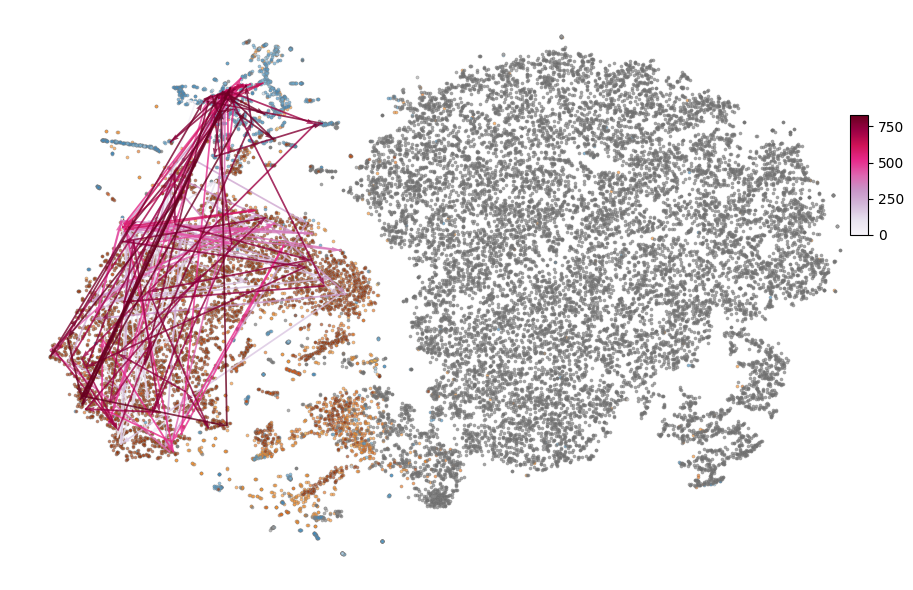

In [35]:
fig